In [ ]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
# --- Initial Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:


# --- 2. Load the Dataset ---
# Make sure you have uploaded 'hotel_bookings.csv' to your Colab session
try:
    df = pd.read_csv('hotel_bookings.csv')
    print("Dataset loaded successfully!")
    print("Initial data shape:", df.shape)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'hotel_bookings.csv' not found.")

Dataset loaded successfully!
Initial data shape: (119390, 32)

First 5 rows of the dataset:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babi


--- Starting Exploratory Data Analysis (EDA) ---


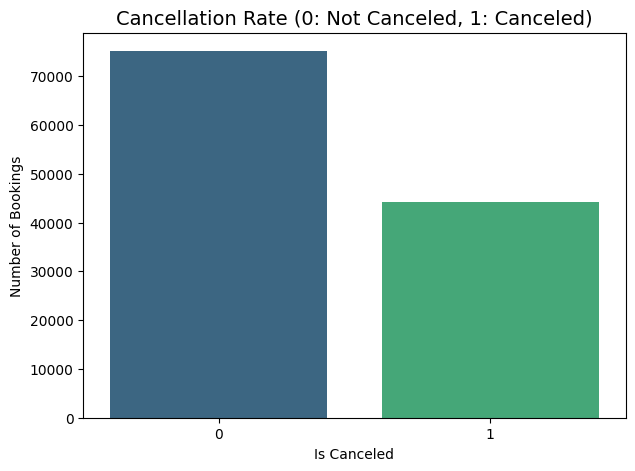

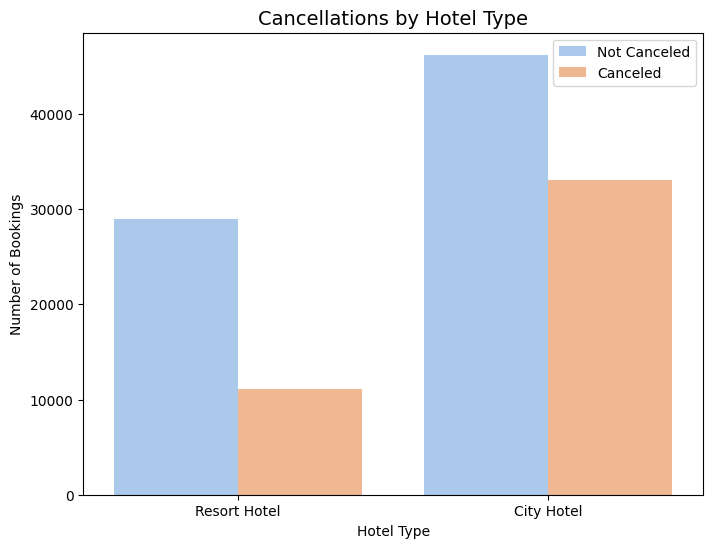

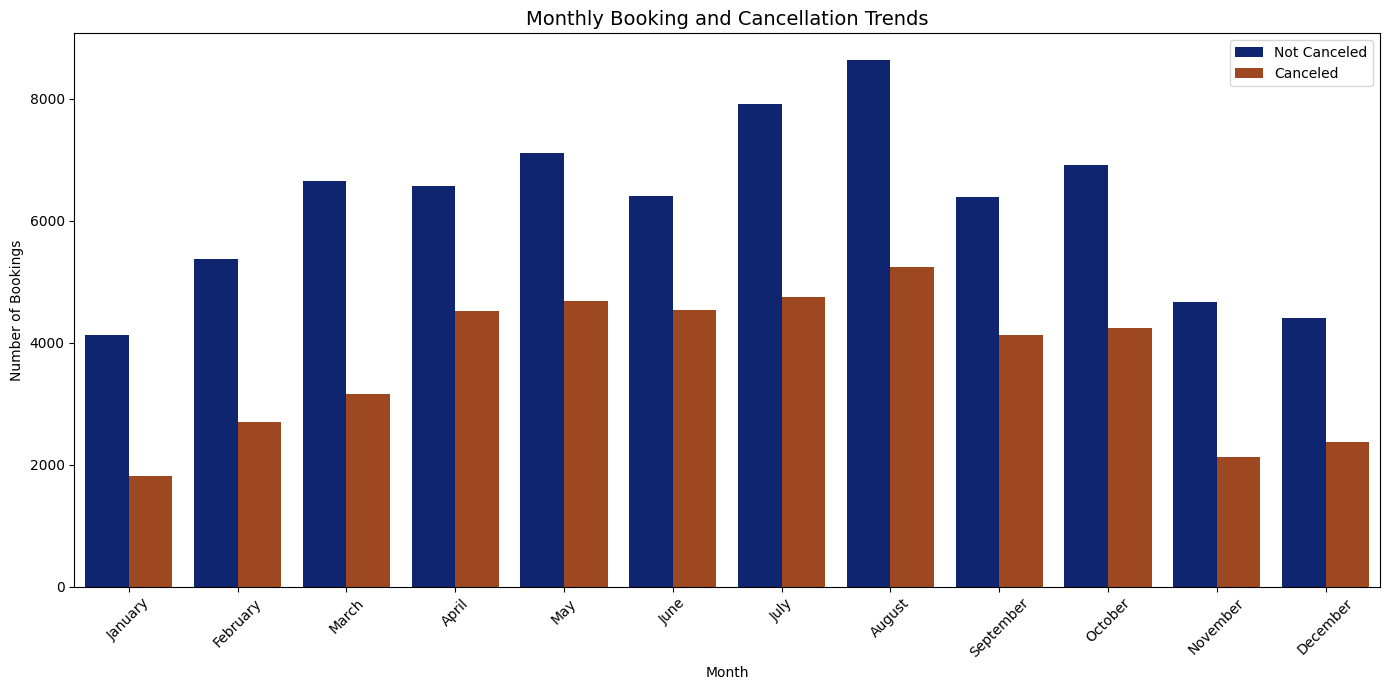

--- EDA Complete ---


In [ ]:
# --- 3. Exploratory Data Analysis (EDA) ---
print("\n--- Starting Exploratory Data Analysis (EDA) ---")

# Plot 1: Cancellation Rate
plt.figure(figsize=(7, 5))
sns.countplot(x='is_canceled', data=df, palette='viridis')
plt.title('Cancellation Rate (0: Not Canceled, 1: Canceled)', fontsize=14)
plt.xlabel('Is Canceled')
plt.ylabel('Number of Bookings')
plt.show()

# Plot 2: Cancellations by Hotel Type
plt.figure(figsize=(8, 6))
sns.countplot(x='hotel', hue='is_canceled', data=df, palette='pastel')
plt.title('Cancellations by Hotel Type', fontsize=14)
plt.xlabel('Hotel Type')
plt.ylabel('Number of Bookings')
plt.legend(['Not Canceled', 'Canceled'])
plt.show()

# Plot 3: Monthly Cancellations
plt.figure(figsize=(14, 7))
# Ensure the months are in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
sns.countplot(x='arrival_date_month', data=df, hue='is_canceled', order=month_order, palette='dark')
plt.title('Monthly Booking and Cancellation Trends', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.legend(['Not Canceled', 'Canceled'])
plt.tight_layout()
plt.show()

print("--- EDA Complete ---")

In [ ]:
# --- 4. Data Cleaning and Feature Engineering ---
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Fill missing values for specific columns
df['company'] = df['company'].fillna(0)
df['agent'] = df['agent'].fillna(0)
df['country'] = df['country'].fillna('Undefined')
df['children'] = df['children'].fillna(0)
print("Missing values handled.")

# Remove bookings where there are no guests
zero_guest_filter = (df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)
df_cleaned = df[~zero_guest_filter]
print(f"Removed {zero_guest_filter.sum()} bookings with zero guests.")

# Drop columns that are not useful for prediction or cause data leakage
useless_cols = ['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type',
                'booking_changes', 'reservation_status', 'country', 'reservation_status_date']
df_ml = df_cleaned.drop(useless_cols, axis=1)
print(f"Dropped columns: {', '.join(useless_cols)}")


# --- 5. Preprocessing for Modeling (Encoding & Transformation) ---

# Manual mapping for categorical features (as per your original code)
df_ml['hotel'] = df_ml['hotel'].map({'Resort Hotel': 0, 'City Hotel': 1})
df_ml['arrival_date_month'] = df_ml['arrival_date_month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})
df_ml['meal'] = df_ml['meal'].map({'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})
df_ml['market_segment'] = df_ml['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3, 'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})
df_ml['distribution_channel'] = df_ml['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3, 'GDS': 4})
df_ml['reserved_room_type'] = df_ml['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6, 'L': 7, 'B': 8, 'P': 9})
df_ml['deposit_type'] = df_ml['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2})
df_ml['customer_type'] = df_ml['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})
print("Categorical variables encoded.")

# Handle any remaining NaN values, specifically in the 'adr' column
df_ml['adr'] = df_ml['adr'].fillna(df_ml['adr'].median())

# Apply log transformation to skewed numerical features to normalize their distribution
log_cols = ['lead_time', 'adr', 'agent', 'company']
for col in log_cols:
    # Use np.log1p which calculates log(1+x) to handle zero values
    df_ml[col] = np.log1p(df_ml[col].astype(float))

print("Numerical variables transformed using log transformation.")


--- Starting Data Cleaning and Preprocessing ---
Missing values handled.
Removed 180 bookings with zero guests.
Dropped columns: days_in_waiting_list, arrival_date_year, assigned_room_type, booking_changes, reservation_status, country, reservation_status_date
Categorical variables encoded.
Numerical variables transformed using log transformation.


In [ ]:
# --- 6. Model Training and Comparison ---
print("\n--- Starting Model Training and Comparison ---")

# Define features (X) and target (y)
X = df_ml.drop('is_canceled', axis=1)
y = df_ml['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Data split into training and testing sets. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Fill any remaining NaN values in training and testing sets
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
print("Filled remaining NaN values in training and testing sets.")


# Define the models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # For ROC AUC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'ROC AUC Score': roc_auc})
    print(f"Completed training for: {name}")

# Display the results in a DataFrame
results_df = pd.DataFrame(results)
print("\n--- Model Comparison Results ---")
print(results_df)
print("--- Model Training and Comparison Complete ---")


--- Starting Model Training and Comparison ---
Data split into training and testing sets. Train shape: (83447, 24), Test shape: (35763, 24)
Filled remaining NaN values in training and testing sets.
Completed training for: Logistic Regression
Completed training for: Decision Tree
Completed training for: Random Forest
Completed training for: XGBoost
[LightGBM] [Info] Number of positive: 30939, number of negative: 52508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 83447, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370762 -> initscore=-0.528948
[LightGBM] [Info] Start training from score -0.528948
Completed training for: LightGBM

--- Model Comparison Results ---
                 Model  

In [ ]:
# --- 7. Random Forest Fine-Tuning ---
print("\n--- Starting Random Forest Fine-Tuning with GridSearchCV ---")

# Define a smaller, more focused parameter grid for faster tuning
param_grid = {
    'n_estimators': [150, 200], # Number of trees
    'max_depth': [20, 30],      # Maximum depth of the trees
    'min_samples_split': [2, 5], # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]   # Minimum samples required at a leaf node
}

# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation. n_jobs=-1 uses all available CPU cores.
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

# Get the best model from the grid search
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("\n--- Tuned Random Forest Performance ---")
print(f"Tuned Accuracy: {accuracy_tuned:.4f}")
print(f"Tuned Precision: {precision_tuned:.4f}")
print(f"Tuned ROC AUC Score: {roc_auc_tuned:.4f}")
print("--- Random Forest Fine-Tuning Complete ---")


--- Starting Random Forest Fine-Tuning with GridSearchCV ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

--- Tuned Random Forest Performance ---
Tuned Accuracy: 0.8677
Tuned Precision: 0.8679
Tuned ROC AUC Score: 0.9337
--- Random Forest Fine-Tuning Complete ---


In [ ]:
# --- 8. Save the Final Model and Columns ---
print("\n--- Saving the Final Model and Column List ---")

# Save the fine-tuned Random Forest model
joblib.dump(best_rf, 'tuned_random_forest_model.joblib')
print("Tuned model saved to 'tuned_random_forest_model.joblib'")

# Save the list of columns used for training the model
joblib.dump(X.columns, 'model_columns.pkl')
print("Model columns saved to 'model_columns.pkl'")


--- Saving the Final Model and Column List ---
Tuned model saved to 'tuned_random_forest_model.joblib'
Model columns saved to 'model_columns.pkl'
